In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the word2int dictionaries
with open("/content/word2int_en.pkl", "rb") as f:
  en_words = pickle.load(f)

with open("/content/word2int_fr.pkl", "rb") as f:
  fr_words = pickle.load(f)

# Load the word embedding
en_embeddings = np.load("/content/embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("/content/embeddings_fr.npz")["embeddings"]

In [4]:
# Define some helper functions
def tokenize(sentence, token_mapping):
  tokenized = []

  for word in sentence.lower().split(" "):
    try:
      tokenized.append(token_mapping[word])
    except KeyError:
      tokenized.append(-1)

  return tokenized

def embed(tokens, embeddings):
  embed_size = embeddings.shape[1]

  output = np.zeros((len(tokens), embed_size))

  for i, token in enumerate(tokens):
    if token == -1:
      output[i] = np.zeros((1, embed_size))
    else:
      output[i] = embeddings[token]

  return output

The scaled-dot product attention consists of two matrix multiplications and a softmax scaling as shown in the diagram. It takes three input matrices, the queries, keys, and values.

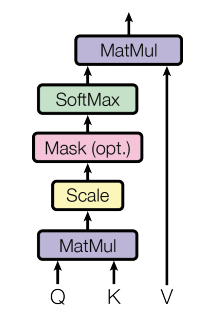

Mathematically, this is expressed as

$$
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$

where $Q$, $K$, and $V$ are the queries, keys, and values matrices respectively, and $d_k$ is the dimension of the keys. In practice, Q, K, and V all have the same dimensions. This form of attention is faster and more space-efficient than what you implemented before since it consists of only matrix multiplications instead of a learned feed-forward layer.

Conceptually, the first matrix multiplication is a measure of the similarity between the queries and the keys. This is transformed into weights using the softmax function. These weights are then applied to the values with the second matrix multiplication resulting in output attention vectors. Typically, decoder states are used as the queries while encoder states are the keys and values.

In [9]:
def softmax(x, axis = 0):
  return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis = axis), axis)

def calculate_weights(queries, keys):
  dot = np.matmul(queries, keys.T) / np.sqrt(keys.shape[1])
  # Each row in weights must sum to 1
  weights = softmax(dot, axis = 1)

  return weights

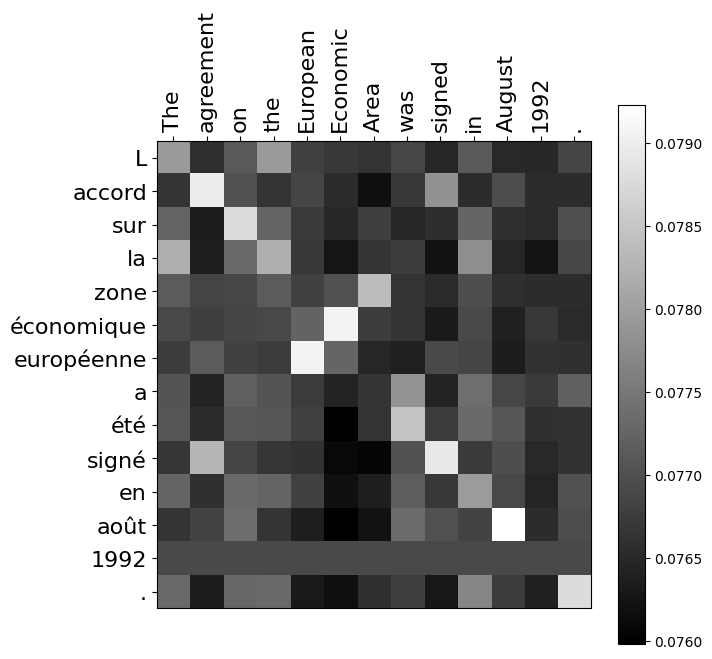

In [14]:
# Tokenize example sentences in English and French, then get their embeddings
sentence_en = "The agreement on the European Economic Area was signed in August 1992 ."
tokenized_en = tokenize(sentence_en, en_words)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "L accord sur la zone économique européenne a été signé en août 1992 ."
tokenized_fr = tokenize(sentence_fr, fr_words)
embedded_fr = embed(tokenized_fr, fr_embeddings)

# These weights indicate alignment between words in English and French
alignment = calculate_weights(embedded_fr, embedded_en)

# Visualize weights to check for alignment
fig, ax = plt.subplots(figsize = (7,7))
im = ax.imshow(alignment, cmap = "gray")
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=16);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=16);
cbar = fig.colorbar(im, ax=ax)
plt.show()

'''
This is a demonstration of alignment where the model has learned which words in English correspond to words in French.
For example, the words signed and signé have a large weight because they have the same meaning. Typically, these alignments
are learned using linear layers in the model, but you've used pre-trained embeddings here.
'''

In [15]:
def attention_qkv(queries, keys, values):
  weights = calculate_weights(queries, keys)
  return np.matmul(weights, values)

attention_qkv_result = attention_qkv(embedded_fr, embedded_en, embedded_en)

print(f"The shape of the attention_qkv function is {attention_qkv_result.shape}")
print(f"Some elements of the attention_qkv function are \n{attention_qkv_result[0:2,:10]}")

The shape of the attention_qkv function is (14, 300)
Some elements of the attention_qkv function are 
[[-0.04039161 -0.00275749  0.00389873  0.04842744 -0.02472726  0.01435613
  -0.00370253 -0.0619686  -0.00206159  0.01615228]
 [-0.04083253 -0.00245985  0.00409068  0.04830341 -0.02479128  0.01447497
  -0.00355203 -0.06196036 -0.00241327  0.01582606]]
